In [1]:
!pip install fastFM

You are using pip version 9.0.1, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


Upload kaggle.json and run this if you run the notebook on colab

In [2]:
!mkdir /root/.kaggle
!cp kaggle.json /root/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: Permission denied
cp: failed to access '/root/.kaggle': Permission denied


In [3]:
import os
import shutil
from  operator import itemgetter
import tqdm

import scipy
import numpy as np
import pandas as pd

from livelossplot import PlotLosses
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
import sklearn.compose
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.linear_model import SGDRegressor
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import NMF


import fastFM.als
import fastFM.sgd
import fastFM.mcmc

from kaggle.api.kaggle_api_extended import KaggleApi
from kaggle.api_client import ApiClient

In [4]:
plt.style.use('dark_background')

In [5]:
def preprocess_game_info_df(game_info_df):
  game_info_df['Genre'] = game_info_df['Genre'].str.replace(' ', '-').str.replace(';', ' ')
  # game_info_df = game_info_df[game_info_df['Platform'] == 'PC']
  game_info_df['Metascore'][game_info_df['Metascore'] == 'not specified'] = 'nan'
  game_info_df['Metascore'] = game_info_df['Metascore'].astype('float') / 100
  game_info_df['Metascore'] = game_info_df['Metascore'].fillna(game_info_df['Metascore'].mean(skipna=True))
  game_info_df['Avg_Userscore'][game_info_df['Avg_Userscore'] == 'tbd'] = 8
  game_info_df['Avg_Userscore'][game_info_df['Avg_Userscore'] == 'not specified'] = 'nan'
  game_info_df['Avg_Userscore'] = game_info_df['Avg_Userscore'].astype('float') / 10
  game_info_df['Avg_Userscore'] = game_info_df['Avg_Userscore'].fillna(game_info_df['Avg_Userscore'].mean(skipna=True))
  return game_info_df


def preprocess_game_comments_df(game_comments_df):
  game_comments_df = pd.read_csv('metacritic_game_user_comments.csv', index_col=0)
  # game_comments_df = game_comments_df[game_comments_df['Platform'] == 'PC']
  game_comments_df = game_comments_df[~game_comments_df['Comment'].isna()]
  return game_comments_df[~game_comments_df['Username'].isna()]

In [6]:
def get_column_inverse_norms(X, tol=1e-5):
    features_matrix_maxes = X.max(axis=0).toarray()
    features_matrix_maxes[np.abs(features_matrix_maxes) < tol] = 1
    return scipy.sparse.spdiags(1.0 / features_matrix_maxes, 0, features_matrix_maxes.shape[1], features_matrix_maxes.shape[1])


def column_normalize_csr_matrix(X, inverse_norms):
    return scipy.sparse.csr_matrix(X @ inverse_norms)

In [7]:
def add_label_encoded_column(df, colname, col_le=None):
  if col_le is None:
    col_le = LabelEncoder().fit(df[colname])
  df[colname + '_label_ID'] = col_le.transform(df[colname])
  return df, col_le


def get_rating_matrix(df, n_items):
  n_users = df['Username_label_ID'].max() + 1
  return scipy.sparse.csr_matrix((df['Userscore'], (df['Username_label_ID'], df['Title_label_ID'])), shape=(n_users, n_items))

In [8]:
def map_dict(rating_dict, username='me'):
  title_ids = title_le.transform(list(rating_dict.keys()))
  raw_df = pd.DataFrame.from_records([{'Username': username, 'Title': title, 'Title_label_ID': title_id, 'Userscore': score} for (title_id, (title, score)) in zip(title_ids, rating_dict.items())])
  return raw_df


def get_ratings_matrix_from_ratings_dict(ratings_df, comments_df, title_le):
  ratings_df['Username_label_ID'] = 0
  return get_rating_matrix(ratings_df, comments_df['Title_label_ID'].max() + 1)

### Genre features for users

In [9]:
## TODO: this methodology is invalid, dimensionality reduction should be fitted to train data
def vectorizer_reducer_pipeline(reducer=NMF, vectorizer=TfidfVectorizer):
    return make_pipeline(
        vectorizer(max_features=5000),
        reducer(n_components=25)
    )


def make_user_game_vectorizer(
        primary_columns=['Title_label_ID', 'Username_label_ID', 'Platform'],
        selected_columns=['Metascore', 'Avg_Userscore'],
        bow_columns=['Genre', 'Comment']):
    column_encoders = [(col, OneHotEncoder(categories='auto'), [col]) for col in primary_columns]
    column_selectors = [(col, StandardScaler(), [col]) for col in selected_columns]
    bow_column_encoders = [(col, vectorizer_reducer_pipeline(), col) for col in bow_columns]
    return sklearn.compose.ColumnTransformer(column_encoders + column_selectors + bow_column_encoders)

In [10]:
default_fm_hyperparams = dict(init_stdev=0.01, rank=50, l2_reg_w=5.0, l2_reg_V=8.0)


def setup_fm(fm_hyperparams):
    return fastFM.als.FMRegression(n_iter=1, **fm_hyperparams)


def train_fm(
        X_train,
        y_train,
        X_test,
        y_test,
        n_iter=25,
        step_size=1,
        fm_hyperparams=default_fm_hyperparams,
        early_stopping=True):
    fm = setup_fm(default_fm_hyperparams)
    fm.fit(X_train, y_train)
    
    liveplot = PlotLosses()

    for i in tqdm.tqdm(range(1, n_iter)):
        fm.fit(X_train, y_train, n_more_iter=1)
        y_pred = fm.predict(X_test)

        liveplot.update({
            'rmse': np.sqrt(mean_squared_error(fm.predict(X_train), y_train)),
            'val_rmse': np.sqrt(mean_squared_error(fm.predict(X_test), y_test)),
            'mae': mean_absolute_error(fm.predict(X_train), y_train),
            'val_mae': mean_absolute_error(fm.predict(X_test), y_test)
        })
        liveplot.draw()
        
    return fm


def did_error_improve(errors, steps):
    if len(errors) <= steps:
        return True
    else:
        return min(errors[:-steps]) >= min(errors[-steps:])


def train_mcmc_fm(
        X_train_val,
        y_train_val,
        val_size=0.1,
        n_iter=25,
        step_size=1,
        init_stdev=0.1,
        rank=50,
        early_stopping=True,
        early_stopping_patience=5):
    fm = fastFM.mcmc.FMRegression(n_iter=1, rank=rank, init_stdev=init_stdev)
    
    
    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=val_size, random_state=0)
    fm.fit_predict(X_train, y_train, X_val)
    
    liveplot = PlotLosses()
    plt.style.use('dark_background')

    tqdm_iter = tqdm.tqdm(range(1, n_iter))
    for i in tqdm_iter:
        y_pred = fm.fit_predict(X_train, y_train, X_val, n_more_iter=1)

        current_val_metric = np.sqrt(mean_squared_error(fm.predict(X_val), y_val))
        liveplot.update({
            'rmse': np.sqrt(mean_squared_error(fm.predict(X_train), y_train)),
            'val_rmse': current_val_metric,
            'mae': mean_absolute_error(fm.predict(X_train), y_train),
            'val_mae': mean_absolute_error(fm.predict(X_val), y_val)
        })
        liveplot.draw()
        checked_steps = [item['val_rmse'] for item in liveplot.logs]
        if not did_error_improve(checked_steps, early_stopping_patience):
            tqdm_iter.close()
            break
        
    return fm, liveplot

### User data

In [11]:
def get_my_ratings(ratings_dict):
    rated_titles = pd.Series(list(ratings_dict.keys()))
    title_ids = title_le.transform(rated_titles)
    ratings = list(ratings_dict.values())
    my_ratings = scipy.sparse.csr_matrix((ratings, (np.zeros_like(ratings), title_ids)), shape=(1, ratings_matrix.shape[1]))
    return my_ratings


def get_my_user_encoding(ratings_matrix, my_ratings, n_similar=10):
    user_similarities = cosine_similarity(ratings_matrix, my_ratings)
    similar_user_indices = user_similarities.argsort(axis=0)[::-1][:n_similar,0]
    similar_user_matrix_data = (user_similarities[similar_user_indices][:,0], (np.zeros((n_similar,)), similar_user_indices))
    similar_user_encoding = scipy.sparse.csr_matrix(similar_user_matrix_data, shape=(1, n_rows))
    game_encoding_matrix = scipy.sparse.spdiags(np.ones((n_cols,)), diags=0, m=n_cols, n=n_cols)
    similar_user_matrix_data = (user_similarities[similar_user_indices][:,0], (np.zeros((n_similar,)), similar_user_indices))
    return scipy.sparse.csr_matrix(similar_user_matrix_data, shape=(1, n_rows))


def get_restricted_game_info_df(game_info_df):
    restricted_game_info_df = game_info_df.copy()
    restricted_game_info_df['Username_label_ID'] = 0
    restricted_game_info_df = pd.concat([restricted_game_info_df[restricted_game_info_df['Platform'] == 'PC'], restricted_game_info_df[restricted_game_info_df['Platform'] != 'PC']])
    restricted_game_info_df = restricted_game_info_df.drop_duplicates(subset=['Title'])
    return restricted_game_info_df


def get_mine_features_with_restricted_df(similar_user_encoding, restricted_game_info_df, vectorizer, n_cols, n_rows):
    game_encoding_matrix = scipy.sparse.spdiags(np.ones((n_cols,)), diags=0, m=n_cols, n=n_cols)
    similar_user_encoding = get_my_user_encoding(ratings_matrix, my_ratings)
    X_user_encoding = scipy.sparse.vstack([similar_user_encoding for __ in range(n_cols)])
    X_mine = scipy.sparse.hstack([X_user_encoding, game_encoding_matrix])
    
    X_mine_features = vectorizer.transform(restricted_game_info_df)
    
    X_mine_features[:, :X_user_encoding.shape[1]] = X_user_encoding
    return X_mine_features

In [12]:
api = KaggleApi(ApiClient())
api.authenticate()
if not os.path.exists('metacritic-video-game-comments.zip'):
    api.dataset_download_files(dataset='dahlia25/metacritic-video-game-comments', unzip=True)

In [13]:
!head metacritic_game_info.csv

,Title,Year,Publisher,Genre,Platform,Metascore,Avg_Userscore,No_Players
0,The Legend of Zelda: Ocarina of Time,1998,Nintendo,Action Adventure;Fantasy,Nintendo64,99,9.1,1 Player
1,Tony Hawk's Pro Skater 2,2000,NeversoftEntertainment,Sports;Alternative;Skateboarding,PlayStation,98,7.4,1-2 
2,Grand Theft Auto IV,2008,RockstarNorth,Action Adventure;Modern;Modern;Open-World,PlayStation3,98,7.5,1 Player
3,SoulCalibur,1999,Namco,Action;Fighting;3D,Dreamcast,98,8.6,1-2 
4,Grand Theft Auto IV,2008,RockstarNorth,Action Adventure;Modern;Modern;Open-World,Xbox360,98,7.9,1 Player
5,Super Mario Galaxy,2007,Nintendo,Action;Platformer;Platformer;3D;3D,Wii,97,9.0,No Online Multiplayer
6,Super Mario Galaxy 2,2010,NintendoEADTokyo,Action;Platformer;Platformer;3D;3D,Wii,97,9.1,No Online Multiplayer
7,Grand Theft Auto V,2014,RockstarNorth,Action Adventure;Modern;Open-World,XboxOne,97,7.8,Up to 30 
8,Grand Theft Auto V,2013,RockstarNorth,Modern;Action Adventure;Modern;Open-World,PlayStation3,97,8.3,Up to 16

## Game data

In [14]:
game_info_df = pd.read_csv('metacritic_game_info.csv', index_col=0)
game_info_df = preprocess_game_info_df(game_info_df)
game_info_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 0 to 4999
Data columns (total 8 columns):
Title            5000 non-null object
Year             5000 non-null object
Publisher        5000 non-null object
Genre            5000 non-null object
Platform         5000 non-null object
Metascore        5000 non-null float64
Avg_Userscore    5000 non-null float64
No_Players       4993 non-null object
dtypes: float64(2), object(6)
memory usage: 351.6+ KB


/home/kuba/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/home/kuba/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Metascore vs Userscore

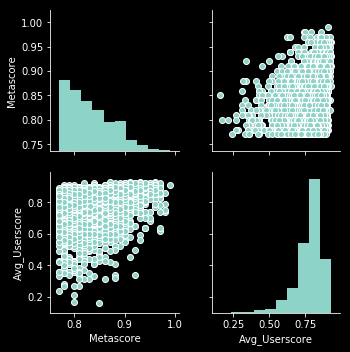

In [15]:
sns.pairplot(game_info_df[['Metascore', 'Avg_Userscore']]);

In [16]:
game_comments_df = pd.read_csv('metacritic_game_user_comments.csv', index_col=0)
game_comments_df = preprocess_game_comments_df(game_comments_df)

User score by platform

In [17]:
game_comments_df.groupby('Platform')['Userscore'].agg('mean').sort_values(ascending=False)

Platform
Nintendo64         9.241566
Dreamcast          9.138158
PlayStation        9.095576
GameBoyAdvance     9.091310
GameCube           8.975855
WiiU               8.862412
Switch             8.813239
PlayStationVita    8.783923
Wii                8.645642
PlayStation2       8.634731
DS                 8.484739
3DS                8.482959
Xbox               8.474645
PSP                8.390300
not specified      7.861789
PlayStation4       7.771425
PlayStation3       7.609727
Xbox360            7.364606
XboxOne            7.279851
PC                 7.196018
Name: Userscore, dtype: float64

User score by publisher

In [18]:
publisher_average_scores_with_count = game_comments_df.merge(game_info_df, on=['Title', 'Platform']).groupby('Publisher')['Userscore'].agg(['mean', 'count'])
publisher_average_scores_with_count[publisher_average_scores_with_count['count'] > 10].sort_values('mean', ascending=False)

,mean,count
Publisher,,
Quest,9.700000,50
CavedogEntertainment,9.675000,40
DreamworksGames,9.657143,35
MPSLabs,9.652174,46
PlanetMoonStudios,9.642857,14
Overworks,9.637681,69
NuFX,9.600000,25
"1C,ElementalGames,1CCompany",9.580645,31
Inti,9.578947,19


In [19]:
users_index = game_comments_df['Username'].unique()
titles_index = game_info_df['Title'].values

from sklearn.preprocessing import LabelEncoder
users_le = LabelEncoder().fit(users_index)
titles_le = LabelEncoder().fit(titles_index)

In [20]:
game_comments_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 283957 entries, 0 to 283982
Data columns (total 5 columns):
Title        283957 non-null object
Platform     283957 non-null object
Userscore    283957 non-null int64
Comment      283957 non-null object
Username     283957 non-null object
dtypes: int64(1), object(4)
memory usage: 13.0+ MB


In [21]:
game_comments_df.describe()

,Userscore
count,283957.000000
mean,7.618386
std,3.131708
min,0.000000
25%,7.000000
50%,9.000000
75%,10.000000
max,10.000000


## Restrict titles to these that have reviews

In [22]:
def get_column_values_with_min_occurrences(df, col, min_occurrences=5):
    col_value_counts = df[col].value_counts()
    return col_value_counts[col_value_counts >= min_occurrences].index

In [23]:
user_comment_counts = game_comments_df['Username'].value_counts()
title_counts = game_comments_df['Title'].value_counts()

more_than_one_comment_game_comments_df = game_comments_df[
    game_comments_df['Title'].isin(get_column_values_with_min_occurrences(game_comments_df, 'Title')) &
    game_comments_df['Username'].isin(get_column_values_with_min_occurrences(game_comments_df, 'Username'))
]

In [24]:
more_than_one_comment_game_comments_df.shape

(113643, 5)

In [25]:
game_info_df = game_info_df[game_info_df['Title'].isin(more_than_one_comment_game_comments_df['Title'])]
game_info_df, title_le = add_label_encoded_column(game_info_df, 'Title')

game_info_df = game_info_df.sort_values(by='Title_label_ID')

In [26]:
used_comments_df, username_le = add_label_encoded_column(more_than_one_comment_game_comments_df, 'Username')
used_comments_df, title_le = add_label_encoded_column(used_comments_df, 'Title', title_le)

/home/kuba/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [27]:
used_comments_df = used_comments_df.merge(game_info_df[['Title', 'Avg_Userscore', 'Metascore', 'Publisher', 'Platform', 'Genre']], on=['Title', 'Platform'])

In [28]:
used_comments_df.columns

Index(['Title', 'Platform', 'Userscore', 'Comment', 'Username',
       'Username_label_ID', 'Title_label_ID', 'Avg_Userscore', 'Metascore',
       'Publisher', 'Genre'],
      dtype='object')

In [29]:
#used_comments_df['Userscore'] = used_comments_df['Userscore'] - used_comments_df['Userscore'].median()

In [30]:
vectorizer = make_user_game_vectorizer()

In [31]:
%%time
X = vectorizer.fit_transform(used_comments_df)

CPU times: user 3min 44s, sys: 7.63 s, total: 3min 51s
Wall time: 3min 39s


In [32]:
X.shape

(113841, 12382)

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, used_comments_df['Userscore'], test_size=0.1, random_state=0)

## Machine learning for predicting Userscore


### SGD Linear Regression

In [34]:
lin_reg = SGDRegressor(alpha=1, l1_ratio=0.5, random_state=0)

In [35]:
%%time
lin_reg.fit(X_train, y_train)

CPU times: user 1.37 s, sys: 129 ms, total: 1.5 s
Wall time: 1.32 s


SGDRegressor(alpha=1, average=False, early_stopping=False, epsilon=0.1,
             eta0=0.01, fit_intercept=True, l1_ratio=0.5,
             learning_rate='invscaling', loss='squared_loss', max_iter=1000,
             n_iter_no_change=5, penalty='l2', power_t=0.25, random_state=0,
             shuffle=True, tol=0.001, validation_fraction=0.1, verbose=0,
             warm_start=False)

In [36]:
y_pred_lin_reg = lin_reg.predict(X_test)

In [37]:
np.sqrt(mean_squared_error(y_pred_lin_reg , y_test))

2.4388761229865503

### Factorization Machines

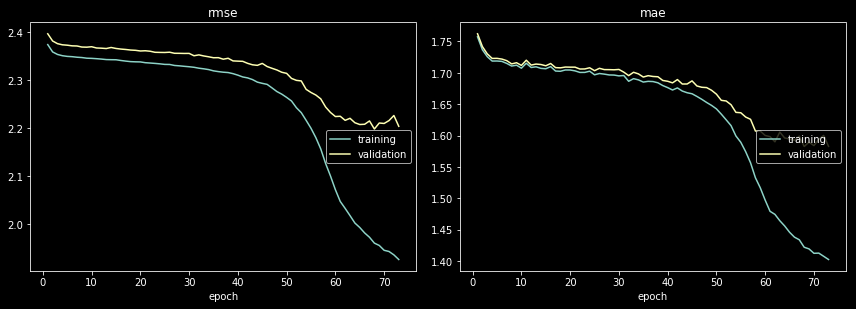

rmse:
training   (min:    1.926, max:    2.374, cur:    1.926)
validation (min:    2.198, max:    2.397, cur:    2.204)

mae:
training   (min:    1.402, max:    1.757, cur:    1.402)
validation (min:    1.582, max:    1.762, cur:    1.583)
CPU times: user 3min 48s, sys: 33.9 s, total: 4min 21s
Wall time: 3min 19s


In [38]:
%%time
fm, liveplot = train_mcmc_fm(X_train, y_train, n_iter=500, rank=10, init_stdev=1e-3, early_stopping_patience=5)

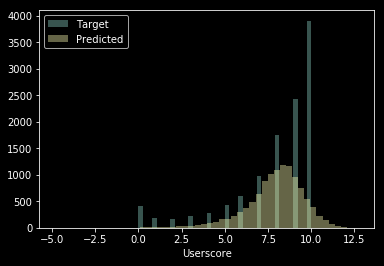

In [39]:
y_pred = fm.predict(X_test)

sns.distplot(y_test, kde=False, label='Target');
sns.distplot(y_pred, kde=False, label='Predicted')
plt.legend();

## Error distribution

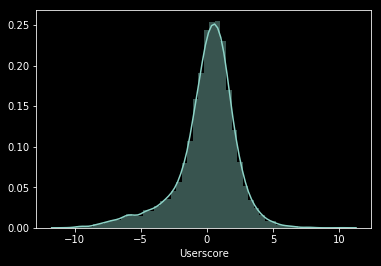

In [40]:
sns.distplot(y_test - y_pred);

In [41]:
np.sqrt(mean_squared_error(fm.predict(X_test) , y_test))

2.2213452179512236

## Preparing data for recommendations

In [42]:
matrix_data = (used_comments_df['Userscore'], (used_comments_df['Username_label_ID'], used_comments_df['Title_label_ID']))
n_rows = matrix_data[1][0].max() + 1
n_cols = matrix_data[1][1].max() + 1
n_rows, n_cols

(10229, 2081)

In [43]:
n_rows + n_cols

12310

In [44]:
ratings_matrix = scipy.sparse.csr_matrix(matrix_data, shape=(n_rows, n_cols))

## Mine ratings

In [45]:
ratings_dict = {
  'The Witcher 3: Wild Hunt': 10,
  'Grand Theft Auto: Vice City': 10,
  'Diablo II: Lord of Destruction': 6,
  'Medieval II: Total War': 8,
  'Gothic': 7,
  'Age of Empires II: The Conquerors Expansion': 9,
  'Age of Mythology': 9,
  'Planescape: Torment': 10,
  'Deus Ex': 9,
  'Fallout' : 10,
  'Fallout 2': 10,
  'Fallout 3': 5,
  "Sid Meier's Civilization II": 9,
  'Antichamber': 9,
  'FIFA Soccer 11': 2,
  'The Sims': 1,
  "Baldur's Gate II: Shadows of Amn": 8,
  'Call of Duty 2': 7,
  'Darwinia': 9,
  'Starcraft': 9,
  'Tiger Woods PGA Tour 2004': 1,
  'Madden NFL 2004': 1,
  'Colin McRae Rally 2.0': 2
}

In [46]:
my_ratings = get_my_ratings(ratings_dict)

### Getting users similar to me

In [47]:
game_encoding_matrix = scipy.sparse.spdiags(np.ones((n_cols,)), diags=0, m=n_cols, n=n_cols)

In [48]:
similar_user_encoding = get_my_user_encoding(ratings_matrix, my_ratings)

In [49]:
restricted_game_info_df = get_restricted_game_info_df(game_info_df)
restricted_game_info_df['Comment'] = 'foo'
X_mine = get_mine_features_with_restricted_df(similar_user_encoding, restricted_game_info_df, vectorizer, n_cols, n_rows)

/home/kuba/anaconda3/lib/python3.6/site-packages/scipy/sparse/_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)


In [50]:
fm_predicted_ratings = fm.predict(X_mine)
fm_predicted_ratings = fm_predicted_ratings / fm_predicted_ratings.max() * 10

In [51]:
lin_reg_predicted_ratings = lin_reg.predict(X_mine)
lin_reg_predicted_ratings = lin_reg_predicted_ratings / lin_reg_predicted_ratings.max() * 10

In [52]:
predictions_df = pd.DataFrame({'LinScore': lin_reg_predicted_ratings, 'FMScore': fm_predicted_ratings}, index=restricted_game_info_df.index)
predicted_ratings_df = pd.concat([predictions_df, restricted_game_info_df], axis=1).sort_values(by='FMScore', ascending=False)

In [53]:
predicted_ratings_df.shape

(2081, 13)

In [54]:
mine_ratings_df = predicted_ratings_df[predicted_ratings_df['Title'].isin(ratings_dict.keys())].sort_values(by='Title')

In [55]:
mine_ratings_df['MyScore'] = list(map(itemgetter(1), sorted(ratings_dict.items(), key=itemgetter(0))))

### Best PC Games for me according to Factorization Machines

In [56]:
predicted_ratings_df[predicted_ratings_df['Platform'] == 'PC'].iloc[:50]

,LinScore,FMScore,Title,Year,Publisher,Genre,Platform,Metascore,Avg_Userscore,No_Players,Title_label_ID,Username_label_ID,Comment
107,9.780449,9.826210,The Witcher 3: Wild Hunt,2015,CDProjektRedStudio,Action-RPG Role-Playing Action-RPG,PC,0.93,0.93,No Online Multiplayer,1804,0,foo
326,9.660589,9.805921,Planescape: Torment,1999,BlackIsleStudios,Role-Playing General PC-style-RPG Western-Style,PC,0.91,0.92,No Online Multiplayer,1252,0,foo
4387,9.150850,9.787035,Vanquish,2017,PlatinumGames,Action Shooter Third-Person Arcade,PC,0.78,0.91,No Online Multiplayer,1950,0,foo
245,9.696151,9.764880,The Witcher 3: Wild Hunt - Blood and Wine,2016,CDProjektRedStudio,Role-Playing Action-RPG,PC,0.92,0.92,not specified,1805,0,foo
390,9.625258,9.757516,Portal,2007,ValveSoftware,Action Shooter Shooter First-Person Sci-Fi Sci...,PC,0.90,0.92,1 Player,1283,0,foo
415,9.625258,9.757516,Half-Life 2: Episode Two,2007,ValveSoftware,Action Shooter Shooter First-Person Sci-Fi Sci...,PC,0.90,0.92,1 Player,705,0,foo
410,9.625360,9.738837,Deus Ex,2000,IonStorm,Action-Adventure Sci-Fi Sci-Fi General,PC,0.90,0.92,1 Player,334,0,foo
830,9.554330,9.721203,Counter-Strike,2000,TheCounter-StrikeTeam,Action Shooter Shooter First-Person Modern Tac...,PC,0.88,0.92,Online Multiplayer,257,0,foo
41,9.802387,9.716721,Baldur's Gate II: Shadows of Amn,2000,BioWare,Role-Playing PC-style-RPG PC-style-RPG Western...,PC,0.95,0.92,Up to 6,77,0,foo
1100,9.434400,9.714326,Fallout 2,1998,BlackIsleStudios,Role-Playing First-Person First-Person PC-styl...,PC,0.86,0.91,No Online Multiplayer,501,0,foo


### Predicted scores for games rated by me

In [57]:
mine_ratings_df.sort_values('FMScore', ascending=False)

,LinScore,FMScore,Title,Year,Publisher,Genre,Platform,Metascore,Avg_Userscore,No_Players,Title_label_ID,Username_label_ID,Comment,MyScore
107,9.780449,9.826210,The Witcher 3: Wild Hunt,2015,CDProjektRedStudio,Action-RPG Role-Playing Action-RPG,PC,0.93,0.93,No Online Multiplayer,1804,0,foo,10
326,9.660589,9.805921,Planescape: Torment,1999,BlackIsleStudios,Role-Playing General PC-style-RPG Western-Style,PC,0.91,0.92,No Online Multiplayer,1252,0,foo,10
410,9.625360,9.738837,Deus Ex,2000,IonStorm,Action-Adventure Sci-Fi Sci-Fi General,PC,0.90,0.92,1 Player,334,0,foo,9
41,9.802387,9.716721,Baldur's Gate II: Shadows of Amn,2000,BioWare,Role-Playing PC-style-RPG PC-style-RPG Western...,PC,0.95,0.92,Up to 6,77,0,foo,8
1100,9.434400,9.714326,Fallout 2,1998,BlackIsleStudios,Role-Playing First-Person First-Person PC-styl...,PC,0.86,0.91,No Online Multiplayer,501,0,foo,10
727,9.505537,9.698587,Starcraft,1998,BlizzardEntertainment,Strategy Real-Time Sci-Fi Sci-Fi Command,PC,0.88,0.91,1-8,1581,0,foo,9
917,9.421178,9.621561,Diablo II: Lord of Destruction,2001,BlizzardNorth,Role-Playing Action-RPG Action-RPG,PC,0.87,0.90,1-8,352,0,foo,6
706,9.456672,9.574171,Age of Empires II: The Conquerors Expansion,2000,EnsembleStudios,Strategy Real-Time Historic Historic Command,PC,0.88,0.90,1-8,22,0,foo,9
503,9.443385,9.553756,Age of Mythology,2002,EnsembleStudios,Strategy Real-Time Fantasy General Fantasy,PC,0.89,0.89,1-12,27,0,foo,9
784,9.407853,9.518676,Medieval II: Total War,2006,CreativeAssembly,Strategy Real-Time Historic General,PC,0.88,0.89,Online Multiplayer,956,0,foo,8


## Ranking metrics for predictions

Since I'm interested more in the order of predictions than it's numerical accuracy, I'll use ranking metric for final evaluation (Spearman's rank correlation coefficient).

In [58]:
scipy.stats.spearmanr(mine_ratings_df['FMScore'], mine_ratings_df['MyScore'])

SpearmanrResult(correlation=0.6664764310422301, pvalue=0.0005156669443773782)

In [59]:
scipy.stats.spearmanr(mine_ratings_df['LinScore'], mine_ratings_df['MyScore'])

SpearmanrResult(correlation=0.6054290062457806, pvalue=0.002204431990943383)